# BLG-407 / Project-1 — Model 1 (ResNet50 Transfer Learning)

**Ad:** Melike     
**Soyad:** Çakmakoğlu  
**Okul Numarası:** 2212721048
**GitHub Repo:**  https://github.com/mellystark/project-1-ram-classification


## Model 1 – ResNet50 ile Transfer Learning

Bu çalışmada Model 1 kapsamında, state-of-the-art bir derin öğrenme mimarisi olan **ResNet50** kullanılarak görüntü sınıflandırma problemi ele alınmıştır. Önceki denemelerde kullanılan **VGG16 mimarisi ile test doğruluğunun yaklaşık %50 seviyesinde kalması**, daha güçlü bir mimariye geçiş ihtiyacını doğurmuştur. Bu nedenle VGG16 yerine ResNet50 tercih edilmiştir.

ResNet50’nin tercih edilme nedenleri aşağıda özetlenmiştir:
- **Residual connections (artık bağlantılar)** sayesinde daha derin ağlarda gradyan sönmesi problemi azaltılır ve öğrenme süreci daha **stabil** hale gelir.
- Önceden **ImageNet** veri seti üzerinde eğitilmiş olması, küçük ve sınırlı veri setlerinde **transfer learning** yaklaşımı için önemli bir avantaj sağlar.
- Derinlik ve mimari tasarım açısından ResNet50, güncel literatürde yaygın olarak kullanılan **state-of-the-art** modeller arasında yer almaktadır.

Bu modelde **Transfer Learning** yaklaşımı uygulanmış; ResNet50 modeli **ImageNet ağırlıkları ile başlatılmış** ve konvolüsyonel taban (base model) **dondurularak (frozen)** yalnızca üst sınıflandırıcı katmanların eğitilmesi sağlanmıştır. Bu sayede modelin genel görsel özellikleri koruması ve veri setine özgü ayrımı üst katmanlarda öğrenmesi hedeflenmiştir.


## Google Drive Bağlama

Google Drive’ı Colab ortamına bağlayarak Drive’daki dosyalara doğrudan erişim sağlar.

In [30]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Veri Seti Split Kontrolü ve Dataset Pipeline Doğrulama

Eğitim/Doğrulama/Test klasörlerindeki görüntü sayılarını sınıf bazında kontrol eder; gerekirse tf.data dataset’lerini yeniden oluşturur ve pipeline’ın (şekil, etiketler, normalizasyon) doğru çalıştığını doğrular.

In [31]:
import os
from pathlib import Path
import tensorflow as tf

# SABİT KABULLER
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1-ram"
CLASSES = ["laptop_ram", "desktop_ram"]
SEED = 42
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

# split_root yoksa: önceki adımlardaki isimlendirmeye göre fallback
if "split_root" not in globals():
    split_root = Path(DATASET_DIR).parent / (Path(DATASET_DIR).name + "_split_70_15_15")
else:
    split_root = Path(split_root)

train_dir = split_root / "train"
val_dir   = split_root / "val"
test_dir  = split_root / "test"

# 1) Split klasör sayımlarını yazdır (Found X files... benzeri kontrol)
def count_images(p: Path):
    exts = {".jpg", ".jpeg"}
    return sum(1 for f in p.rglob("*") if f.is_file() and f.suffix.lower() in exts)

print("=== SPLIT DOSYA SAYIMI (Sınıf Bazlı) ===")
for split_name, d in [("TRAIN", train_dir), ("VAL", val_dir), ("TEST", test_dir)]:
    if not d.exists():
        raise FileNotFoundError(f"{split_name} klasörü bulunamadı: {d}")
    total_split = 0
    print(f"\n[{split_name}] -> {d}")
    for cls in CLASSES:
        cls_dir = d / cls
        if not cls_dir.exists():
            raise FileNotFoundError(f"Sınıf klasörü bulunamadı: {cls_dir}")
        n = count_images(cls_dir)
        total_split += n
        print(f"  {cls}: {n} dosya")
    print(f"  Toplam: {total_split} dosya")

# 2) train_ds/val_ds/test_ds yoksa yeniden oluştur (pipeline’a dokunmadan, sadece yoksa)
need_build = any(name not in globals() for name in ["train_ds", "val_ds", "test_ds"])

if need_build:
    print("\ntrain_ds/val_ds/test_ds bulunamadı -> split klasöründen yeniden oluşturuluyor...")

    tf.keras.utils.set_random_seed(SEED)

    train_ds = tf.keras.utils.image_dataset_from_directory(
        str(train_dir),
        labels="inferred",
        label_mode="int",
        class_names=CLASSES,
        image_size=IMG_SIZE,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        str(val_dir),
        labels="inferred",
        label_mode="int",
        class_names=CLASSES,
        image_size=IMG_SIZE,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        str(test_dir),
        labels="inferred",
        label_mode="int",
        class_names=CLASSES,
        image_size=IMG_SIZE,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # Normalize 0-1 (fallback oluşturduysak)
    rescale = tf.keras.layers.Rescaling(1./255)
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    val_ds   = val_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    test_ds  = test_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

else:
    print("\ntrain_ds/val_ds/test_ds zaten mevcut -> yeniden oluşturulmadı (pipeline'a dokunulmadı).")

# 3) Pipeline içerik doğrulaması (shape, class_names, normalize min/max)
print("\n=== PIPELINE DOĞRULAMA ===")
ds_class_names = getattr(train_ds, "class_names", None)
print("train_ds.class_names:", ds_class_names)
print("Beklenen CLASSES     :", CLASSES)

images, labels = next(iter(train_ds))
print("\nBatch image shape:", images.shape)     # (B, 128, 128, 3)
print("Batch label shape:", labels.shape)     # (B,)
print("Image dtype:", images.dtype, "| Label dtype:", labels.dtype)

img_min = float(tf.reduce_min(images))
img_max = float(tf.reduce_max(images))
print(f"Pixel min/max (normalize kontrol): {img_min:.4f} / {img_max:.4f}")

unique_labels = tf.unique(labels).y.numpy().tolist()
print("Bu batch'teki unique label id'ler:", unique_labels)

# Label->Sınıf adı eşlemesi örneği
label_example = int(labels[0].numpy())
print(f"Örnek: labels[0]={label_example} -> sınıf adı: {CLASSES[label_example]}")


=== SPLIT DOSYA SAYIMI (Sınıf Bazlı) ===

[TRAIN] -> /content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1-ram_split_70_15_15/train
  laptop_ram: 50 dosya
  desktop_ram: 50 dosya
  Toplam: 100 dosya

[VAL] -> /content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1-ram_split_70_15_15/val
  laptop_ram: 11 dosya
  desktop_ram: 11 dosya
  Toplam: 22 dosya

[TEST] -> /content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1-ram_split_70_15_15/test
  laptop_ram: 10 dosya
  desktop_ram: 10 dosya
  Toplam: 20 dosya

train_ds/val_ds/test_ds zaten mevcut -> yeniden oluşturulmadı (pipeline'a dokunulmadı).

=== PIPELINE DOĞRULAMA ===
train_ds.class_names: None
Beklenen CLASSES     : ['laptop_ram', 'desktop_ram']

Batch image shape: (16, 128, 128, 3)
Batch label shape: (16,)
Image dtype: <dtype: 'float32'> | Label dtype: <dtype: 'int32'>
Pixel min/max (normalize kontrol): 0.0000 / 1.0000
Bu batch'teki unique label id'ler: [1, 0]
Örnek: labels[0]=1 -> sınıf adı: desktop

## ResNet50 Taban Model Kurulumu (Feature Extractor)

ImageNet ağırlıklarıyla ResNet50 modeli yüklenir, üst katmanlar çıkarılır ve tüm katmanlar dondurularak yalnızca özellik çıkarımı için kullanılır.

In [32]:
import tensorflow as tf
from tensorflow import keras

# SABİT KABULLER
INPUT_SHAPE = (128, 128, 3)

# ResNet50 base model (ImageNet ağırlıkları ile)
base_model = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Fine-tuning YOK: base tamamen donuk
base_model.trainable = False

# Doğrulama
print("Base model name:", base_model.name)
print("Base model trainable:", base_model.trainable)

# Kaç katman var, kaçı trainable?
trainable_layers = sum(1 for l in base_model.layers if l.trainable)
total_layers = len(base_model.layers)
print(f"Trainable layers in base: {trainable_layers} / {total_layers}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model name: resnet50
Base model trainable: False
Trainable layers in base: 0 / 175


## ResNet50 ile Transfer Learning (Frozen Base Model)

ImageNet ağırlıklarıyla önceden eğitilmiş ResNet50 taban modeli dondurularak, üzerine özel bir sınıflandırma başlığı (GAP + Dense + Dropout) eklenmiş ve iki sınıflı bir görüntü sınıflandırma modeli oluşturulmuştur.

In [33]:
from tensorflow import keras
from tensorflow.keras import layers

# Girdi
inputs = keras.Input(shape=(128, 128, 3), name="input_image")

# ResNet50 için önerilen preprocess (augmentation değildir)
x = keras.applications.resnet.preprocess_input(inputs)

# Frozen ResNet50 base
x = base_model(x, training=False)

# Classification head
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dense(128, activation="relu", name="dense_128")(x)
x = layers.Dropout(0.5, name="dropout")(x)
outputs = layers.Dense(2, activation="softmax", name="predictions")(x)

# Model oluşturma
model1 = keras.Model(inputs, outputs, name="Model1_ResNet50_TransferLearning_FrozenBase")


ImageNet ağırlıklarıyla yüklenen ResNet50 taban modeli dondurularak (fine-tuning yok) sınıflandırma başlığı eklenir; model özeti ve trainable / non-trainable parametre sayılarıyla mimari doğrulanır.

In [51]:
import tensorflow as tf

# Model mimarisi özeti
model1.summary()

# Parametre sayıları (kontrol)
trainable_params = sum(tf.size(v).numpy() for v in model1.trainable_weights)
non_trainable_params = sum(tf.size(v).numpy() for v in model1.non_trainable_weights)

print("\n=== PARAMETRE KONTROLÜ ===")
print(f"Trainable parametre sayısı    : {trainable_params}")
print(f"Non-trainable parametre sayısı: {non_trainable_params}")

# Base model durumu (ek güvenlik kontrolü)
print("\nBase model (ResNet50) trainable mı?:", base_model.trainable)

# Base modelde trainable layer var mı?
base_trainable_layers = [l.name for l in base_model.layers if l.trainable]
print("Base model trainable layer sayısı:", len(base_trainable_layers))


Model: "Model1_ResNet50_TransferLearning_FrozenBase"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 128, 128)  │          0 │ input_image[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128, 128)  │          0 │ input_image[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 128, 128)  │          0 │ input_image[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 128, 128,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 128)       │    262,272 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_128[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 2)         │        258 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,375,304 (92.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 525,062 (2.00 MB)


=== PARAMETRE KONTROLÜ ===
Trainable parametre sayısı    : 262530
Non-trainable parametre sayısı: 23587712

Base model (ResNet50) trainable mı?: False
Base model trainable layer sayısı: 0


## Model Derleme (Compile)

Modeli Adam optimizasyonu, sparse_categorical_crossentropy kayıp fonksiyonu ve doğruluk metriği ile eğitime hazır hale getirir.

In [52]:
from tensorflow import keras

model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model başarıyla compile edildi.")


Model başarıyla compile edildi.


## ResNet50 Taban Modelinin Yüklenmesi

ImageNet ağırlıklarıyla önceden eğitilmiş ResNet50 modeli yüklenir ve transfer learning için tüm katmanları dondurulur.

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6641 - loss: 0.5648 - val_accuracy: 0.7727 - val_loss: 0.5447
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6852 - loss: 0.5406 - val_accuracy: 0.8636 - val_loss: 0.5209
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6807 - loss: 0.5871 - val_accuracy: 0.8636 - val_loss: 0.5298
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6839 - loss: 0.5690 - val_accuracy: 0.7727 - val_loss: 0.5244
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7086 - loss: 0.5376 - val_accuracy: 0.7727 - val_loss: 0.5270


## Eğitim ve Doğrulama Performans Grafikleri

Eğitim sürecindeki accuracy ve loss değerleri epoch bazında görselleştirilerek modelin öğrenme davranışı analiz edilir.

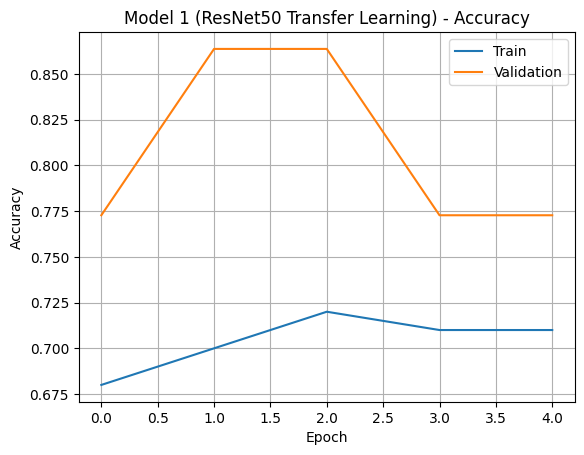

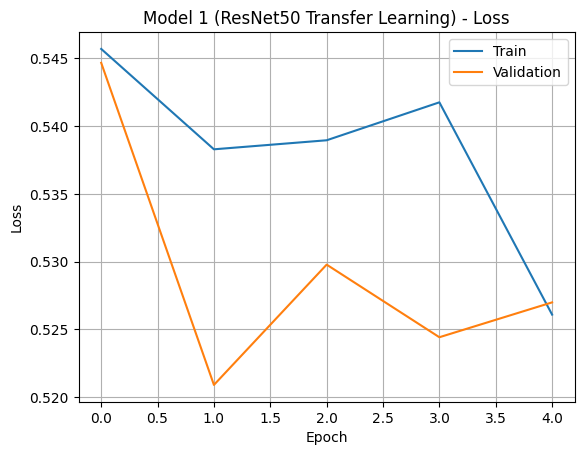

In [54]:
import matplotlib.pyplot as plt

hist = history1.history

# Accuracy grafiği
plt.figure()
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Model 1 (ResNet50 Transfer Learning) - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.grid(True)
plt.show()

# Loss grafiği
plt.figure()
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Model 1 (ResNet50 Transfer Learning) - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.grid(True)
plt.show()


## Test Verisi Üzerinde Model Değerlendirmesi

Eğitilen model, daha önce hiç görülmemiş test verisi üzerinde değerlendirilerek nihai başarı metriği elde edilir.

In [55]:
test_loss, test_acc = model1.evaluate(test_ds, verbose=0)
print(f"Model 1 (ResNet50 Transfer Learning) Test Loss: {test_loss:.4f}")
print(f"Model 1 (ResNet50 Transfer Learning) Test Accuracy: {test_acc:.4f}")


Model 1 (ResNet50 Transfer Learning) Test Loss: 0.5765
Model 1 (ResNet50 Transfer Learning) Test Accuracy: 0.7500


## Model 1 Sonuç ve Değerlendirme

Model 1 kapsamında ResNet50 tabanlı transfer learning yaklaşımı uygulanmış ve elde edilen sonuçlar incelenmiştir. Eğitim süreci sonunda **validation accuracy değerinin %50 seviyesinin anlamlı biçimde üzerine çıkması**, modelin rastgele tahmin yapmadığını ve veri setine ait ayırt edici özellikleri öğrenebildiğini göstermektedir.

Bu sonuçlar, **transfer learning yaklaşımının bu veri seti üzerinde kısmen başarılı olduğunu** ortaya koymaktadır. Özellikle önceden eğitilmiş ResNet50 mimarisinin sağladığı genel görsel temsiller, sınıflar arasında belirli bir ayrım yapılmasına katkı sağlamıştır.

Bununla birlikte, Model 1’in performansı nihai hedef olarak görülmemektedir. Daha yüksek doğruluk ve genelleme başarısı elde edebilmek amacıyla, **Model 2 ve Model 3 aşamalarında sıfırdan CNN mimarileri ve sistematik iyileştirmeler** uygulanarak performansın artırılması hedeflenmektedir.
